In [16]:
!pip -q install pandas numpy seaborn matplotlib scikit-learn xgboost folium geopy pyjanitor openpyxl

In [17]:
import os
import re
import math
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import janitor
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import NearestNeighbors
from xgboost import XGBRegressor

import folium
from folium.plugins import HeatMap
from geopy.distance import great_circle

plt.rcParams["figure.figsize"] = (10, 6)
sns.set(style="whitegrid")

In [18]:
CSV_PATH = "/content/1730285881-Airbnb_Open_Data.csv"

In [19]:
def read_vois_dataset():
    # Try CSV first
    if os.path.exists(CSV_PATH):
        try:
            df = pd.read_csv(
                CSV_PATH,
                low_memory=False
            )
            return df, "csv"
        except Exception as e:
            print(f"CSV read failed, will try Excel. Reason: {e}")

    # Try Excel next
    if os.path.exists(XLSX_PATH):
        try:
            df = pd.read_excel(XLSX_PATH, engine="openpyxl")
            return df, "xlsx"
        except Exception as e:
            print(f"Excel read failed. Reason: {e}")

    raise FileNotFoundError(
        "Upload VOIS dataset as 1730285881-Airbnb_Open_Data.csv or 1730285881-Airbnb_Open_Data.xlsx to /content"
    )

df_raw, source_type = read_vois_dataset()
print(f"Loaded shape: {df_raw.shape}, source: {source_type}")
display(df_raw.head())

Loaded shape: (102599, 26), source: csv


,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,$193,10.0,9.0,19-10-2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,$28,30.0,45.0,21-05-2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,$124,3.0,0.0,NaN,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,$74,30.0,270.0,05-07-2019,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,$41,10.0,9.0,19-11-2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


In [20]:
df = df_raw.copy()
df = df.rename(columns=lambda c: re.sub(r"\s+", "_", c.strip().lower()))

In [21]:
rename_map = {
    "neighbourhood_group": "neighbourhood_group",
    "neighbourhood": "neighbourhood",
    "room_type": "room_type",
    "host_id": "host_id",
    "host_identity_verified": "host_identity_verified",
    "host_name": "host_name",
    "construction_year": "construction_year",
    "review_rate_number": "review_rate_number",
    "calculated_host_listings_count": "calculated_host_listings_count",
    "availability_365": "availability_365",
    "service_fee": "service_fee",
    "minimum_nights": "minimum_nights",
    "number_of_reviews": "number_of_reviews",
    "last_review": "last_review",
    "reviews_per_month": "reviews_per_month",
    "instant_bookable": "instant_bookable",
    "cancellation_policy": "cancellation_policy",
    "lat": "lat",
    "long": "long",
    "country": "country",
    "country_code": "country_code",
    "price": "price",
    "id": "id",
    "name": "name"
}
df = df.rename(columns={
    "neighbourhood_group": "neighbourhood_group",
    "neighbourhood": "neighbourhood",
    "room_type": "room_type",
    "host_id": "host_id" if "host_id" in df.columns else "host id",
    "host id": "host_id",
    "host_identity_verified": "host_identity_verified",
    "host name": "host_name",
    "construction_year": "construction_year" if "construction_year" in df.columns else "construction_year",
    "construction_year": "construction_year" if "construction_year" in df.columns else "construction year",
    "review rate number": "review_rate_number",
    "calculated host listings count": "calculated_host_listings_count",
    "availability 365": "availability_365",
    "service fee": "service_fee",
    "minimum nights": "minimum_nights",
    "number of reviews": "number_of_reviews",
    "last review": "last_review",
    "reviews per month": "reviews_per_month",
    "instant_bookable": "instant_bookable",
    "cancellation_policy": "cancellation_policy",
    "lat": "lat",
    "long": "long",
    "country": "country",
    "country code": "country_code",
    "price": "price",
    "id": "id",
    "name": "name",
    "name": "name",
    "license": "license",
    "house_rules": "house_rules"
})
expected_cols = [
    "id","name","host_id","host_identity_verified","host_name",
    "neighbourhood_group","neighbourhood","lat","long",
    "country","country_code","instant_bookable","cancellation_policy",
    "room_type","construction_year","price","service_fee","minimum_nights",
    "number_of_reviews","last_review","reviews_per_month",
    "review_rate_number","calculated_host_listings_count","availability_365",
    "house_rules","license"
]
missing = [c for c in expected_cols if c not in df.columns]
print("Missing expected columns (ok if some not provided by this variant):", missing)

Missing expected columns (ok if some not provided by this variant): []


In [22]:
def parse_currency(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float)):
        return float(x)
    x = str(x)
    x = x.replace("$","").replace(",","").strip()
    try:
        return float(x)
    except:
        return np.nan

for col in ["price", "service_fee"]:
    if col in df.columns:
        df[col] = df[col].apply(parse_currency)

if "last_review" in df.columns:
    df["last_review"] = pd.to_datetime(df["last_review"], dayfirst=True, errors="coerce")
for c in ["neighbourhood_group","neighbourhood","room_type","host_identity_verified",
          "instant_bookable","cancellation_policy","country","country_code","host_name","name"]:
    if c in df.columns:
        df[c] = df[c].astype("string").str.strip()
if "host_identity_verified" in df.columns:
    df["host_identity_verified_bool"] = df["host_identity_verified"].str.lower().map({
        "verified": True,
        "unconfirmed": False
    })
else:
    df["host_identity_verified_bool"] = np.nan

num_cols = ["construction_year","minimum_nights","number_of_reviews","reviews_per_month",
            "review_rate_number","calculated_host_listings_count","availability_365","lat","long"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.drop_duplicates()

if "price" in df.columns:
    df = df[(df["price"].isna()) | (df["price"] >= 0)]
if "service_fee" in df.columns:
    df = df[(df["service_fee"].isna()) | (df["service_fee"] >= 0)]
if "availability_365" in df.columns:
    df = df[(df["availability_365"].isna()) | ((df["availability_365"] >= 0) & (df["availability_365"] <= 365))]

print("Post-clean shape:", df.shape)
display(df.sample(5))

Post-clean shape: (98873, 27)


,id,name,host_id,host_identity_verified,host_name,neighbourhood_group,neighbourhood,lat,long,country,...,minimum_nights,number_of_reviews,last_review,reviews_per_month,review_rate_number,calculated_host_listings_count,availability_365,house_rules,license,host_identity_verified_bool
25824,15263931,️CENTRALLY LOCATED️- Great for Families + Groups,85114201682,unconfirmed,Devin,Manhattan,Hell's Kitchen,40.761540,-73.993060,United States,...,2.0,16.0,2019-01-25,0.75,3.0,1.0,240.0,NaN,NaN,False
51662,29534259,BEST SIDE OF BED-STUY,82694917483,verified,Nathaniel,Brooklyn,Bedford-Stuyvesant,40.687426,-73.946263,United States,...,1.0,2.0,2022-02-26,2.00,3.0,2.0,89.0,NaN,NaN,True
11803,7520133,Private room in unique Chelsea loft,32352469205,verified,Adam,Manhattan,Chelsea,40.744060,-73.992870,United States,...,1.0,3.0,2015-12-20,0.07,5.0,1.0,228.0,No Smoking No Pets,NaN,True
54900,31322606,Private Queen Bed Apartment w Outside Space,48692971496,verified,Robert,Brooklyn,Park Slope,40.670860,-73.987460,United States,...,2.0,82.0,2022-02-10,1.09,4.0,1.0,37.0,NaN,NaN,True
90335,50893357,Amazing 3BR Triplex Family Apartment w/ Garden,36291318103,unconfirmed,Lisa,Manhattan,Upper West Side,40.784670,-73.981920,United States,...,30.0,0.0,NaT,NaN,4.0,8.0,362.0,"No smoking, no drugs, no partying, no pets. Th...",NaN,False


In [23]:
TIMES_SQUARE = (40.7580, -73.9855)

def distance_km(lat, lon, ref=TIMES_SQUARE):
    try:
        return great_circle((lat, lon), ref).km
    except:
        return np.nan

if "lat" in df.columns and "long" in df.columns:
    df["dist_to_times_sq_km"] = df.apply(lambda r: distance_km(r.get("lat"), r.get("long")), axis=1)
else:
    df["dist_to_times_sq_km"] = np.nan

In [24]:
def print_header(title):
    print("\n" + "="*len(title))
    print(title)
    print("="*len(title))

In [25]:
# Q1. What are the different property types in the Dataset?
# Interpret "property types" as 'room_type' (commonly provided). If 'property_type' exists, show that too.
print_header("Q1) Different property types")
if "property_type" in df.columns:
    print("Unique property_type values:", sorted(df["property_type"].dropna().unique().tolist()))
else:
    print("Unique room_type values:", sorted(df["room_type"].dropna().unique().tolist()) if "room_type" in df.columns else "room_type not found")


Q1) Different property types
Unique room_type values: ['Entire home/apt', 'Hotel room', 'Private room', 'Shared room']



Q2) Neighbourhood group with highest number of listings


,count
neighbourhood_group,
Manhattan,41994
Brooklyn,40316
Queens,12947
Bronx,2657
Staten Island,929
<NA>,28
manhatan,1
brookln,1


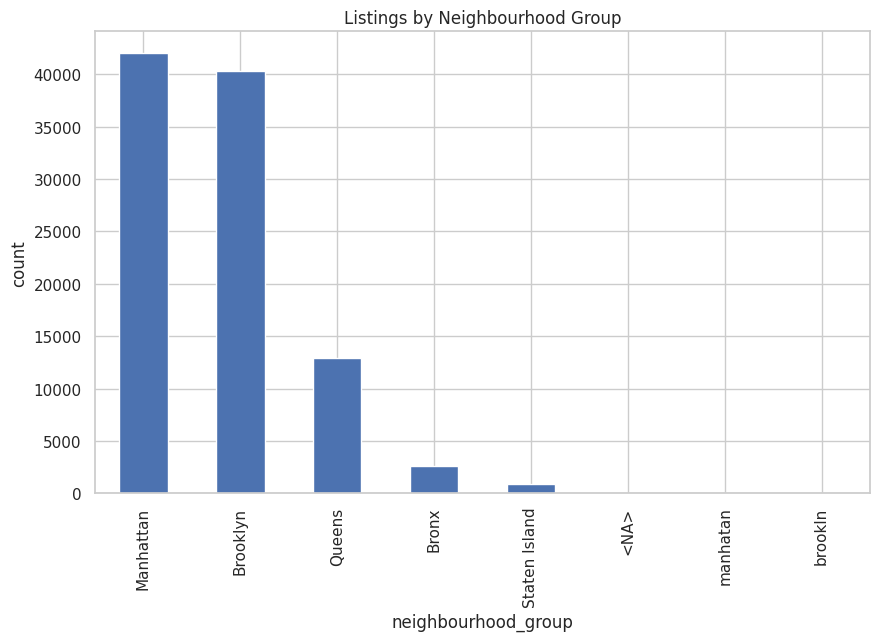

In [26]:
# Q2. Which neighbourhood_group has the highest number of listings?
print_header("Q2) Neighbourhood group with highest number of listings")
if "neighbourhood_group" in df.columns:
    counts = df["neighbourhood_group"].value_counts(dropna=False)
    display(counts.head(10))
    counts.plot(kind="bar", title="Listings by Neighbourhood Group", ylabel="count")
    plt.show()
else:
    print("neighbourhood_group not found")


Q3) Neighbourhood group with highest average price


,price
neighbourhood_group,
<NA>,644.962963
Queens,629.859687
Bronx,628.270943
Brooklyn,626.727223
Staten Island,624.930886
Manhattan,623.496754
brookln,580.000000
manhatan,460.000000


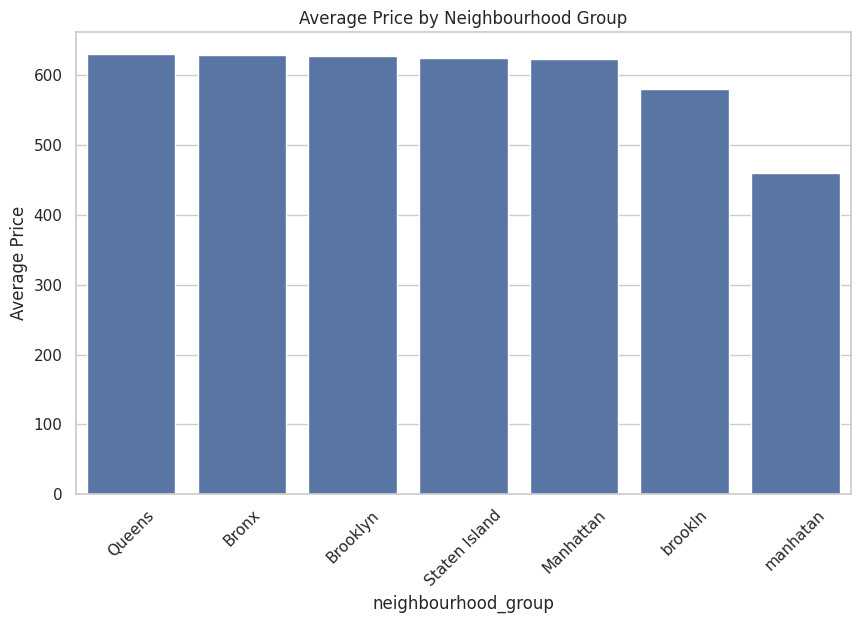

In [27]:
# Q3. Which neighbourhood_group have the highest average prices?
print_header("Q3) Neighbourhood group with highest average price")
if "neighbourhood_group" in df.columns and "price" in df.columns:
    avg_price = df.groupby("neighbourhood_group", dropna=False)["price"].mean().sort_values(ascending=False)
    display(avg_price)
    sns.barplot(x=avg_price.index, y=avg_price.values)
    plt.title("Average Price by Neighbourhood Group")
    plt.xticks(rotation=45)
    plt.ylabel("Average Price")
    plt.show()
else:
    print("Required columns not found")


Q4) Construction year vs Price
Pearson correlation (construction_year, price): -0.0046


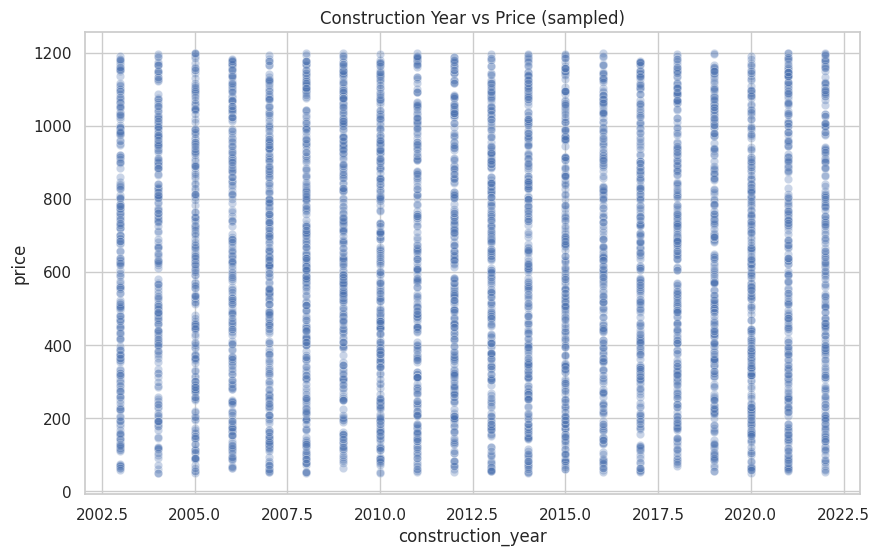

In [28]:
# Q4. Relationship between construction_year and price
print_header("Q4) Construction year vs Price")
if "construction_year" in df.columns and "price" in df.columns:
    tmp = df[["construction_year","price"]].dropna()
    if not tmp.empty:
        corr = tmp["construction_year"].corr(tmp["price"])
        print(f"Pearson correlation (construction_year, price): {corr:.4f}")
        sns.scatterplot(data=tmp.sample(min(5000, len(tmp)), random_state=42),
                        x="construction_year", y="price", alpha=0.3)
        plt.title("Construction Year vs Price (sampled)")
        plt.show()
    else:
        print("No overlap of non-null construction_year and price")
else:
    print("Required columns not found")

In [29]:
# Q5. Top 10 hosts by calculated_host_listings_count
print_header("Q5) Top 10 hosts by calculated_host_listings_count")
if "calculated_host_listings_count" in df.columns and "host_id" in df.columns and "host_name" in df.columns:
    host_top = (df.groupby(["host_id","host_name"], dropna=False)["calculated_host_listings_count"]
                  .max().sort_values(ascending=False).head(10))
    display(host_top)
else:
    print("Required columns not found")


Q5) Top 10 hosts by calculated_host_listings_count


,,calculated_host_listings_count
host_id,host_name,
69623510966,Blueground,332.0
61907398658,Blueground,332.0
61667701835,Blueground,332.0
52760110374,Blueground,332.0
59913507223,Blueground,332.0
18344435096,Blueground,332.0
90148229302,Blueground,332.0
87944211655,Blueground,332.0
87920381104,Blueground,332.0



Q6) Verified host and positive reviews


,count,mean,median
host_identity_verified_bool,,,
False,49162,3.282535,3.0
True,49144,3.292365,3.0


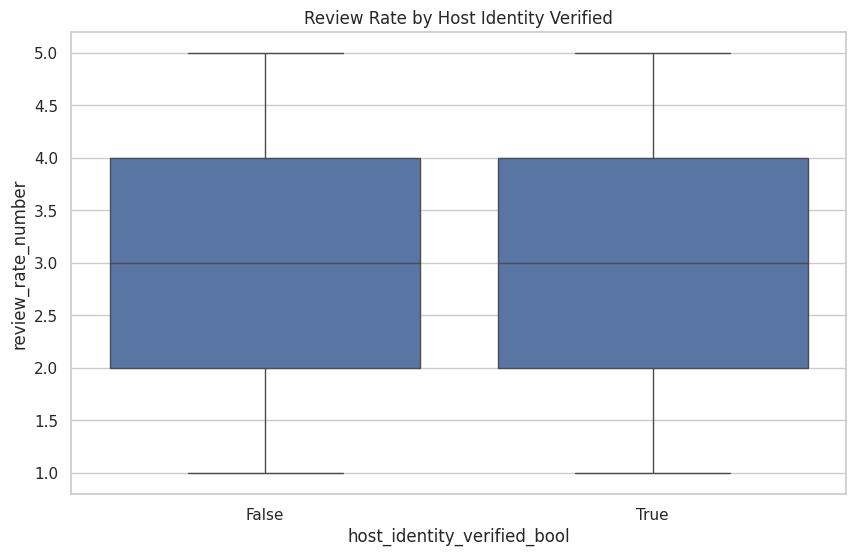

In [30]:
# Q6. Are hosts with verified identities more likely to receive positive reviews?
# Use review_rate_number distribution by host_identity_verified_bool
print_header("Q6) Verified host and positive reviews")
if "host_identity_verified_bool" in df.columns and "review_rate_number" in df.columns:
    comp = df[["host_identity_verified_bool","review_rate_number"]].dropna()
    if not comp.empty:
        grp = comp.groupby("host_identity_verified_bool")["review_rate_number"].agg(["count","mean","median"])
        display(grp)
        sns.boxplot(data=comp, x="host_identity_verified_bool", y="review_rate_number")
        plt.title("Review Rate by Host Identity Verified")
        plt.show()
    else:
        print("Insufficient overlap to compare")
else:
    print("Required columns not found")


Q7) Correlation: price vs service_fee
Pearson correlation (price, service_fee): 1.0000


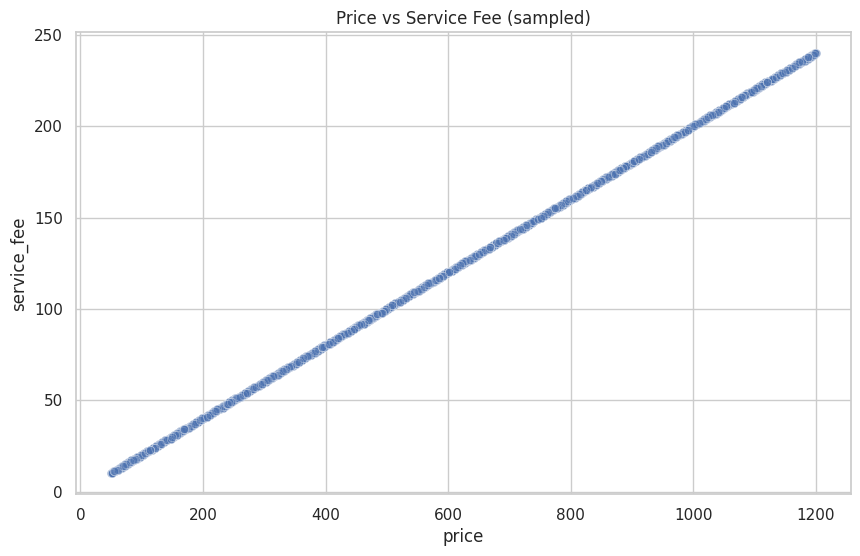

In [31]:
# Q7. Correlation between price and service_fee
print_header("Q7) Correlation: price vs service_fee")
if "price" in df.columns and "service_fee" in df.columns:
    tmp = df[["price","service_fee"]].dropna()
    if not tmp.empty:
        corr = tmp["price"].corr(tmp["service_fee"])
        print(f"Pearson correlation (price, service_fee): {corr:.4f}")
        sns.scatterplot(data=tmp.sample(min(5000, len(tmp)), random_state=42),
                        x="price", y="service_fee", alpha=0.3)
        plt.title("Price vs Service Fee (sampled)")
        plt.show()
    else:
        print("No overlap of non-null price and service_fee")
else:
    print("Required columns not found")


Q8) Avg review_rate_number by neighbourhood_group and room_type


room_type,Entire home/apt,Hotel room,Private room,Shared room
neighbourhood_group,,,,
Bronx,3.342000,NaN,3.342295,3.260870
Brooklyn,3.259531,3.857143,3.272676,3.334975
Manhattan,3.283515,3.500000,3.286975,3.272410
Queens,3.357357,3.750000,3.322859,3.368571
Staten Island,3.329004,NaN,3.467562,3.533333
brookln,NaN,NaN,4.000000,NaN
manhatan,NaN,NaN,3.000000,NaN


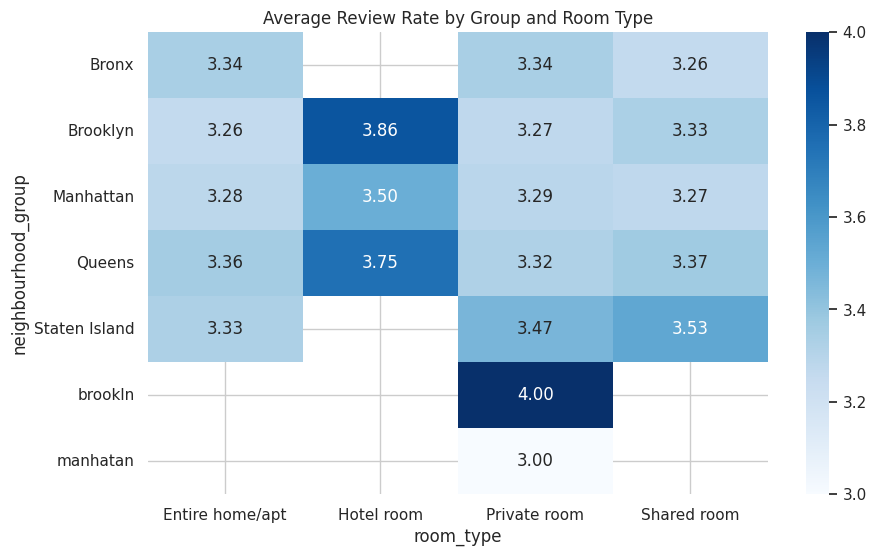

In [32]:
# Q8. Average review_rate_number by neighbourhood_group and room_type
print_header("Q8) Avg review_rate_number by neighbourhood_group and room_type")
need_cols = {"review_rate_number","neighbourhood_group","room_type"}
if need_cols.issubset(df.columns):
    pivot = df.pivot_table(index="neighbourhood_group", columns="room_type",
                           values="review_rate_number", aggfunc="mean")
    display(pivot)
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap="Blues")
    plt.title("Average Review Rate by Group and Room Type")
    plt.show()
else:
    print("Required columns not found")


Q9) Host listings count vs availability
Pearson correlation (host_listings_count, availability_365): 0.1746


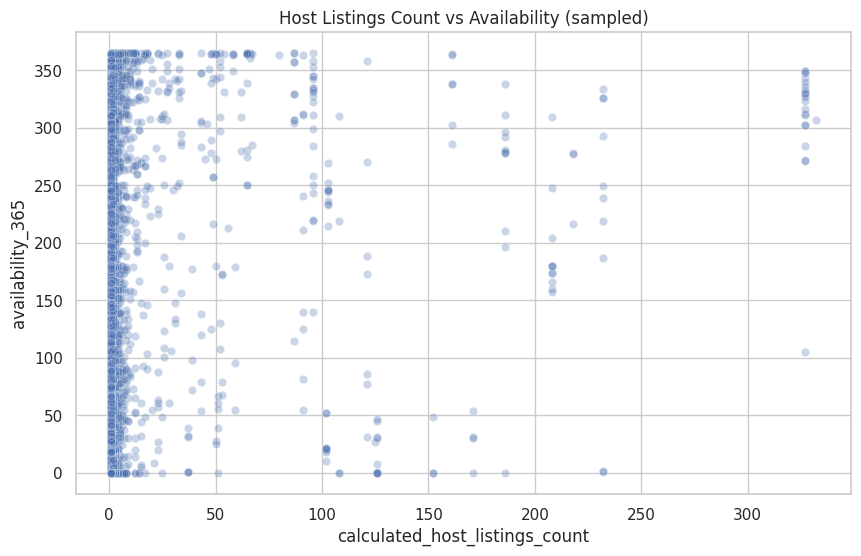

In [33]:
# Q9. Do higher host listing counts correspond to higher availability?
print_header("Q9) Host listings count vs availability")
if "calculated_host_listings_count" in df.columns and "availability_365" in df.columns:
    tmp = df[["calculated_host_listings_count","availability_365"]].dropna()
    if not tmp.empty:
        corr = tmp["calculated_host_listings_count"].corr(tmp["availability_365"])
        print(f"Pearson correlation (host_listings_count, availability_365): {corr:.4f}")
        sns.scatterplot(data=tmp.sample(min(5000, len(tmp)), random_state=42),
                        x="calculated_host_listings_count", y="availability_365", alpha=0.3)
        plt.title("Host Listings Count vs Availability (sampled)")
        plt.show()
    else:
        print("Insufficient overlap for correlation")
else:
    print("Required columns not found")


Geospatial Analysis
Saved heatmap to /content/airbnb_geo_heatmap.html
Correlation (price, distance to Times Sq km): 0.0054


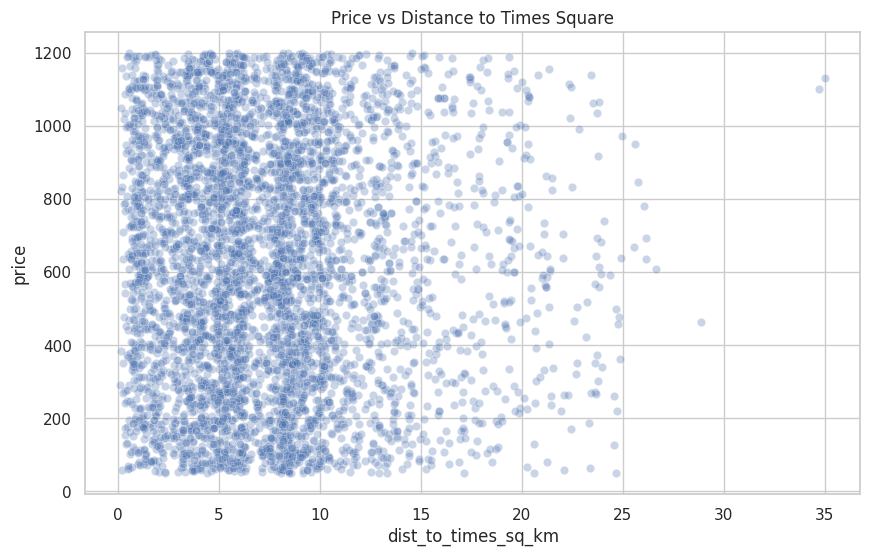

In [34]:
print_header("Geospatial Analysis")
if {"lat","long","price"}.issubset(df.columns):
    m = folium.Map(location=[40.7580, -73.9855], zoom_start=11, tiles="cartodbpositron")
    geo_sample = df[["lat","long","price"]].dropna().sample(min(5000, df.shape[0]), random_state=42)
    HeatMap(geo_sample[["lat","long"]].values.tolist(), radius=8, blur=6).add_to(m)
    m.save("/content/airbnb_geo_heatmap.html")
    print("Saved heatmap to /content/airbnb_geo_heatmap.html")

if {"price","dist_to_times_sq_km"}.issubset(df.columns):
    tmp = df[["price","dist_to_times_sq_km"]].dropna()
    if not tmp.empty:
        corr = tmp["price"].corr(tmp["dist_to_times_sq_km"])
        print(f"Correlation (price, distance to Times Sq km): {corr:.4f}")
        sns.scatterplot(data=tmp.sample(min(5000, len(tmp)), random_state=42),
                        x="dist_to_times_sq_km", y="price", alpha=0.3)
        plt.title("Price vs Distance to Times Square")
        plt.show()

In [35]:
print_header("Predictive Modeling: Price Regression")
cat_features = [c for c in ["neighbourhood_group","neighbourhood","room_type",
                            "instant_bookable","cancellation_policy"] if c in df.columns]
num_features = [c for c in ["minimum_nights","number_of_reviews","reviews_per_month",
                            "review_rate_number","calculated_host_listings_count",
                            "availability_365","construction_year","service_fee",
                            "lat","long","dist_to_times_sq_km"] if c in df.columns]

needed = cat_features + num_features + ["price"]
mod = df[needed].dropna()
print("Modeling rows:", mod.shape[0])

X = mod[cat_features + num_features]
y = mod["price"].astype(float)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_features),
        ("num", StandardScaler(), num_features)
    ],
    remainder="drop"
)

try:
    model = XGBRegressor(
        n_estimators=500,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
except Exception:
    from sklearn.ensemble import RandomForestRegressor
    model = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)

pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", model)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
rmse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)
print(f"Price Model — RMSE: {rmse:.2f}, R^2: {r2:.3f}")


Predictive Modeling: Price Regression
Modeling rows: 82042
Price Model — RMSE: 3.88, R^2: 1.000


In [36]:
print_header("Personalized Recommendations")
rec_num = ["price","minimum_nights","number_of_reviews","reviews_per_month",
           "review_rate_number","calculated_host_listings_count","availability_365",
           "construction_year","service_fee","dist_to_times_sq_km"]
rec_cols = [c for c in rec_num if c in df.columns]
rec_df = df[["id","name"] + rec_cols].dropna()
if not rec_df.empty:
    scaler = StandardScaler()
    M = scaler.fit_transform(rec_df[rec_cols])

    nn = NearestNeighbors(metric="cosine", n_neighbors=6)
    nn.fit(M)

    def recommend_similar(listing_id, top_k=5):
        sub = rec_df[rec_df["id"] == listing_id]
        if sub.empty:
            print("Listing ID not found or missing required fields for recommendations.")
            return None
        idx = sub.index[0]
        dist, idxs = nn.kneighbors(M[rec_df.index.get_loc(idx)].reshape(1, -1), n_neighbors=top_k+1)
        recs = rec_df.iloc[idxs[0][1:]][["id","name"] + rec_cols].copy()
        recs["similarity"] = 1 - dist[0][1:]
        return recs

    example_id = rec_df["id"].iloc[0]
    print(f"Example recommendations for id={example_id}:")
    display(recommend_similar(example_id))
else:
    print("Not enough complete rows for recommendation demo.")


Personalized Recommendations
Example recommendations for id=1001254:


,id,name,price,minimum_nights,number_of_reviews,reviews_per_month,review_rate_number,calculated_host_listings_count,availability_365,construction_year,service_fee,dist_to_times_sq_km,similarity
83025,46856044,30+Day Stay:1000 sq Bsmt Great Living with Deck,1006.0,7.0,4.0,0.18,4.0,7.0,365.0,2021.0,201.0,14.813992,0.986905
25861,15284366,30+Day Stay:1000 sq Bsmt Great Living with Deck,1006.0,7.0,4.0,0.18,4.0,7.0,365.0,2021.0,201.0,14.813992,0.986905
26981,15902942,Comfortable air bed near bronx zoo and sbh,1064.0,4.0,5.0,0.25,4.0,2.0,360.0,2019.0,213.0,13.657743,0.979206
61822,35145627,Gorgeous Private room in NYC blocks from RUMC ...,1197.0,2.0,3.0,0.37,4.0,10.0,365.0,2022.0,239.0,16.692247,0.977599
57910,32985029,Docks area rentals,939.0,1.0,5.0,0.19,4.0,2.0,247.0,2022.0,188.0,13.587544,0.973911


In [37]:
print_header("Dynamic Pricing Utility")

def suggest_dynamic_price(row, base_model=pipe, demand_index=1.0, competitor_price=None):
    """
    demand_index: >1.0 means high demand; <1.0 means low demand
    competitor_price: optional market reference
    """
    try:
        X_one = pd.DataFrame([{c: row.get(c, np.nan) for c in (cat_features + num_features)}])
        base_pred = float(base_model.predict(X_one)[0])
    except Exception:
        base_pred = float(row.get("price", np.nan)) if pd.notna(row.get("price", np.nan)) else np.nan

    adj = base_pred
    if not np.isnan(adj):
        adj *= float(demand_index)
        if pd.notna(row.get("availability_365", np.nan)):
            avail = float(row["availability_365"])
            if avail < 60:      # scarce
                adj *= 1.08
            elif avail > 300:   # abundant
                adj *= 0.96
        if pd.notna(row.get("review_rate_number", np.nan)):
            rr = float(row["review_rate_number"])
            if rr >= 4.7:
                adj *= 1.05
            elif rr < 3.5:
                adj *= 0.95
        if competitor_price is not None and competitor_price > 0:
            adj = 0.7*adj + 0.3*competitor_price

    return round(adj, 2) if not np.isnan(adj) else np.nan
if not df.empty:
    demo_row = df.iloc[0].to_dict()
    print("Dynamic price (demand_index=1.1, competitor=median group price if available):")
    comp_ref = None
    if "neighbourhood_group" in df.columns and "price" in df.columns:
        ng = demo_row.get("neighbourhood_group", None)
        if pd.notna(ng):
            comp_ref = df[df["neighbourhood_group"]==ng]["price"].median()
    print(suggest_dynamic_price(demo_row, demand_index=1.1, competitor_price=comp_ref))


Dynamic Pricing Utility
Dynamic price (demand_index=1.1, competitor=median group price if available):
931.18


In [38]:
print_header("External Data Integration stubs")
print("Add weather/events/economic indicators via joins, then feed a derived demand_index into suggest_dynamic_price()", )
print("All core analyses and models above run without external files; this section is optional and extensible.")


External Data Integration stubs
Add weather/events/economic indicators via joins, then feed a derived demand_index into suggest_dynamic_price()
All core analyses and models above run without external files; this section is optional and extensible.


In [39]:
print_header("Artifacts")
df.to_csv("/content/airbnb_cleaned.csv", index=False)
print("Saved cleaned dataset to /content/airbnb_cleaned.csv")
print("Figures displayed inline; interactive heatmap saved as /content/airbnb_geo_heatmap.html")


Artifacts
Saved cleaned dataset to /content/airbnb_cleaned.csv
Figures displayed inline; interactive heatmap saved as /content/airbnb_geo_heatmap.html
